# Module 4 Project - Movie Recommendation System

By: **Cary Mosley** and **Bryan Santos**

For this project, we decided to build a recommendation system for movies. We want to ensure that our models are not biased towards popular movies. We want to be able to recommend "hidden gems" based on multiple criteria. Our goal is to build a hybrid model that will focus on content based recommendations when we do not have enough data for a user profile and weight our recommendations more towards similar users as we gather more data about our consumers. As ratings tend to be skewed towards popular movies we want to focus on movies that have high ratings but are not simply the most popular movies.

Dataset: https://grouplens.org/datasets/movielens/100k

***

## Package Loads and Data Imports

### Import necesary packages

In [256]:

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline
import surprise
import sklearn
import sklearn.metrics
import datetime
import nltk
import matplotlib.pyplot as plt
import string, re 

from scipy import stats
from math import log
from surprise import Reader, Dataset
from surprise.model_selection import cross_validate
from surprise.prediction_algorithms import SVD
from surprise.prediction_algorithms import KNNWithMeans, KNNBasic, KNNBaseline
from surprise.prediction_algorithms import knns
from surprise.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from surprise.model_selection import LeaveOneOut
from sklearn.metrics.pairwise import linear_kernel
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import cosine, correlation
from collections import defaultdict
from nltk.tokenize import RegexpTokenizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from nltk.tokenize import RegexpTokenizer
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer 
from nltk import word_tokenize
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
lemmatizer = WordNetLemmatizer() 
from surprise import accuracy
from surprise import Reader, Dataset, SVD
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import tensorflow as tf
from scipy import sparse

from keras.layers import Input, Embedding, Flatten, Dot, Dense
from keras.models import Model, load_model as keras_load_model
from keras import losses
from keras.callbacks import EarlyStopping
from keras.utils.np_utils import to_categorical
from sklearn import preprocessing
from keras.preprocessing.text import Tokenizer
from keras import models
from keras import layers
from keras import optimizers
import random
from keras.models import Sequential
from lightfm import LightFM
from lightfm.evaluation import precision_at_k
from lightfm.evaluation import auc_score
from recsys import *
from lightfm.datasets import fetch_movielens



# pd.set_option("display.max_rows", None, "display.max_columns", None)

import warnings
warnings.filterwarnings("ignore")

ModuleNotFoundError: No module named 'lightfm'

In [2]:
%%capture

from tqdm import tqdm_notebook as tqdm
from tqdm import tnrange
tqdm().pandas()

### Data Load and Initial Cleaning

In [3]:
#Import data files
movies_df = pd.read_csv('movies.csv',index_col=False)
ratings_df = pd.read_csv('ratings.csv',index_col=False)
tags_df = pd.read_csv('tags.csv',index_col=False)
links_df = pd.read_csv('links.csv', index_col=False)
plot_df = pd.read_csv('plot.csv', index_col=False, engine='python')

First thing is to look at each file to get an idea of what is contained. Then we will merge any relavent data sets and perform some EDA. We inspect each of the five csv files included.

In [4]:
movies_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [5]:
ratings_df.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [6]:
tags_df.head()

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


In [7]:
links_df.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [8]:
del plot_df['Unnamed: 0']
plot_df.head()

,tmdbId,plot
0,8844,When siblings Judy and Peter discover an encha...
1,15602,A family wedding reignites the ancient feud be...
2,31357,"Cheated on, mistreated and stepped on, the wom..."
3,11862,Just when George Banks has recovered from his ...
4,949,"Obsessive master thief, Neil McCauley leads a ..."


In [9]:
# Double check shape of each df prior to merging
print("movie df - " + str(movies_df.shape))
print("ratings df - " + str(ratings_df.shape))
print("links df - " + str(links_df.shape))
print("plot df - " + str(plot_df.shape))
print("tags df - " + str(tags_df.shape))

movie df - (9742, 3)
ratings df - (100836, 4)
links df - (9742, 3)
plot df - (9741, 2)
tags df - (3683, 4)


In [10]:
movies_df.set_index('movieId')

,title,genres
movieId,,
1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,Jumanji (1995),Adventure|Children|Fantasy
3,Grumpier Old Men (1995),Comedy|Romance
4,Waiting to Exhale (1995),Comedy|Drama|Romance
5,Father of the Bride Part II (1995),Comedy
...,...,...
193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy
193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy
193585,Flint (2017),Drama


In [11]:
# Add IMDB/TMDB links for merging with movie plot gathered from API calls 
df = pd.merge(movies_df,links_df, on='movieId', how='left')

In [12]:
df2 = df.copy()

In [13]:
df.shape

(9742, 5)

In [14]:
df.head()

,movieId,title,genres,imdbId,tmdbId
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,114709,862.0
1,2,Jumanji (1995),Adventure|Children|Fantasy,113497,8844.0
2,3,Grumpier Old Men (1995),Comedy|Romance,113228,15602.0
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,114885,31357.0
4,5,Father of the Bride Part II (1995),Comedy,113041,11862.0


In [15]:
nlp_df = pd.merge(df2,plot_df, on='tmdbId', how='left')

In [16]:
# Merge all movie details with dataset that has ratings
df = pd.merge(ratings_df,df, on="movieId", how="inner")

In [17]:
# Merge to get each movie plot for NLP 
df = pd.merge(df,plot_df, on='tmdbId', how='left')

In [18]:
nlp_df = nlp_df.drop_duplicates(subset=['movieId'], keep='first')
nlp_df

,movieId,title,genres,imdbId,tmdbId,plot
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,114709,862.0,"Led by Woody, Andy's toys live happily in his ..."
1,2,Jumanji (1995),Adventure|Children|Fantasy,113497,8844.0,When siblings Judy and Peter discover an encha...
3,3,Grumpier Old Men (1995),Comedy|Romance,113228,15602.0,A family wedding reignites the ancient feud be...
5,4,Waiting to Exhale (1995),Comedy|Drama|Romance,114885,31357.0,"Cheated on, mistreated and stepped on, the wom..."
7,5,Father of the Bride Part II (1995),Comedy,113041,11862.0,Just when George Banks has recovered from his ...
...,...,...,...,...,...,...
9762,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy,5476944,432131.0,"Ciel learns of a ""Aurora Society"", that is rum..."
9763,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy,5914996,445030.0,"In ancient Disboard, Riku is an angry, young w..."
9764,193585,Flint (2017),Drama,6397426,479308.0,A woman deals with the toxic water scandal in ...
9765,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation,8391976,483455.0,Power users around the world are suddenly comm...


## EDA

### Ratings

**Count per User Rating**

The first data we'll look at is for the collaborative model will just be using the ratings dataframe

In [19]:
#Look at column types
ratings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
userId       100836 non-null int64
movieId      100836 non-null int64
rating       100836 non-null float64
timestamp    100836 non-null int64
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


There are no null values in our dataframe

In [20]:
#Check for null values
ratings_df.isnull().sum()

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

**Rating Distribution**

In [21]:
ratings_df['rating'].value_counts()

4.0    26818
3.0    20047
5.0    13211
3.5    13136
4.5     8551
2.0     7551
2.5     5550
1.0     2811
1.5     1791
0.5     1370
Name: rating, dtype: int64

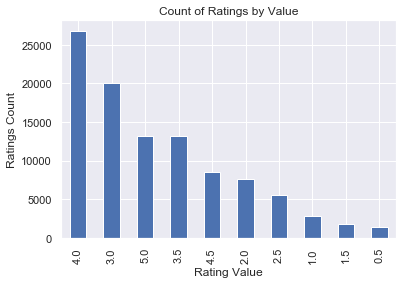

In [22]:

fig, ax = plt.subplots()
ax = ratings_df['rating'].value_counts().plot(kind='bar')
ax.set_xlabel('Rating Value')  # Add an x-label to the axes.
ax.set_ylabel('Ratings Count')  # Add a y-label to the axes.
ax.set_title("Count of Ratings by Value")  # Add a title to the axes.
plt.show()

Text(0, 0.5, 'Ratings Count')

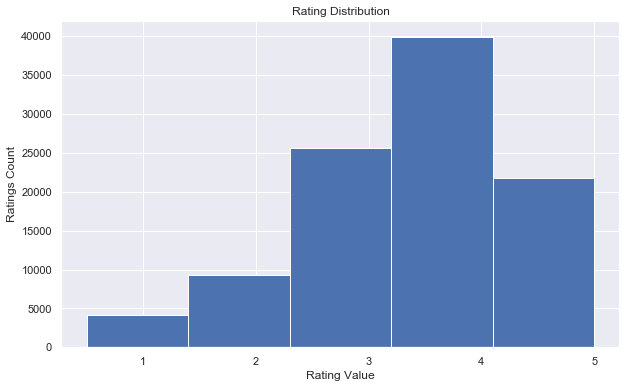

In [23]:
plt.figure(figsize=(10,6))
plt.hist(ratings_df['rating'], bins = 5)
plt.title('Rating Distribution')
plt.xlabel('Rating Value')
plt.ylabel('Ratings Count')

*Observations:*
    
We can see that majority of the movies are rated either 3 or 4 out of 5 stars. The ratings are skewed towards higher ratings and we can see that there are signifcantly more 5 star ratings than those in the lowest bucket.

### Users

**Distribution of User Behavior**

In [24]:
x = ratings_df['userId'].value_counts()
users = x.index[:]
counts = x.iloc[:]

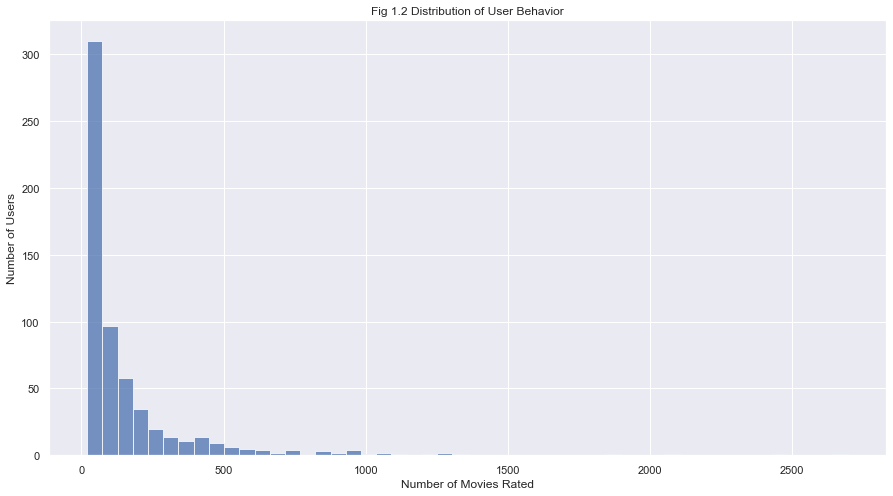

In [25]:
plt.figure(figsize=(15,8))
plt.hist(counts, 50, density=False, alpha=0.75)
plt.xlabel('Number of Movies Rated')
plt.ylabel('Number of Users')
plt.title('Fig 1.2 Distribution of User Behavior')
plt.grid(True)
plt.show()

*Observations:*

It is strange that the vast majority of the users have reviewed very few movies. Yet, there are outliers who have reviewed more than 2,000 movies. This may present a challenge when using User-User similarity as we don't have many points of comparison for the majority of users.

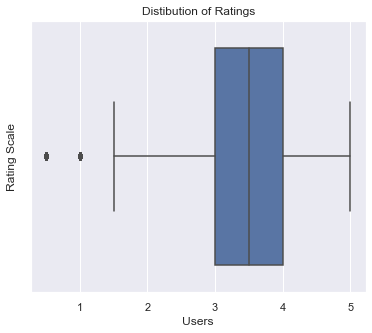

In [26]:
plt.figure(figsize=(6,5))
sns.boxplot(ratings_df['rating'])
plt.xlabel('Users')
plt.ylabel('Rating Scale')
plt.title('Distibution of Ratings')
plt.show()

*Observations:*

We see that the average rating is centred around the 3.5 and the interquartile range is between 3-4. A lot of movies have been highly rated. This may present a difficulty with Item-Item similarity as there is not enough difference in many items to form an accurate picture of the distance between them.

### Genres

We now look into the different genres of the movies reviewed. In order to that, some pre-processing is necessary because each movie has multiple genres listed. This needs to be fleshed out.

In [27]:
def splitDataFrameList(df,target_column,separator):
    ''' df = dataframe to split,
    target_column = the column containing the values to split
    separator = the symbol used to perform the split
    returns: a dataframe with each entry for the target column separated, with each element moved into a new row. 
    The values in the other columns are duplicated across the newly divided rows.
    '''
    def splitListToRows(row,row_accumulator,target_column,separator):
        split_row = row[target_column].split(separator)
        for s in split_row:
            new_row = row.to_dict()
            new_row[target_column] = s
            row_accumulator.append(new_row)
    new_rows = []
    df.apply(splitListToRows,axis=1,args = (new_rows,target_column,separator))
    new_df = pd.DataFrame(new_rows)
    return new_df

In [28]:
genres_df = splitDataFrameList(df,"genres","|")

In [29]:
genres_df.head(5)

,userId,movieId,rating,timestamp,title,genres,imdbId,tmdbId,plot
0,1,1,4.0,964982703,Toy Story (1995),Adventure,114709,862.0,"Led by Woody, Andy's toys live happily in his ..."
1,1,1,4.0,964982703,Toy Story (1995),Animation,114709,862.0,"Led by Woody, Andy's toys live happily in his ..."
2,1,1,4.0,964982703,Toy Story (1995),Children,114709,862.0,"Led by Woody, Andy's toys live happily in his ..."
3,1,1,4.0,964982703,Toy Story (1995),Comedy,114709,862.0,"Led by Woody, Andy's toys live happily in his ..."
4,1,1,4.0,964982703,Toy Story (1995),Fantasy,114709,862.0,"Led by Woody, Andy's toys live happily in his ..."


In [30]:
genres_mean_df = genres_df.groupby('genres', as_index=False).agg({'rating': ['mean','count']})
genres_mean_df.columns = genres_mean_df.columns.droplevel(0)

In [31]:
genres_mean_df.columns = ['Genre', 'Mean', 'Count']
genres_mean_df = genres_mean_df.sort_values("Mean", ascending=False)

In [32]:
genres_mean_df.head(5)

,Genre,Mean,Count
10,Film-Noir,3.920115,870
18,War,3.808294,4859
7,Documentary,3.797785,1219
6,Crime,3.657980,17037
8,Drama,3.655642,42267


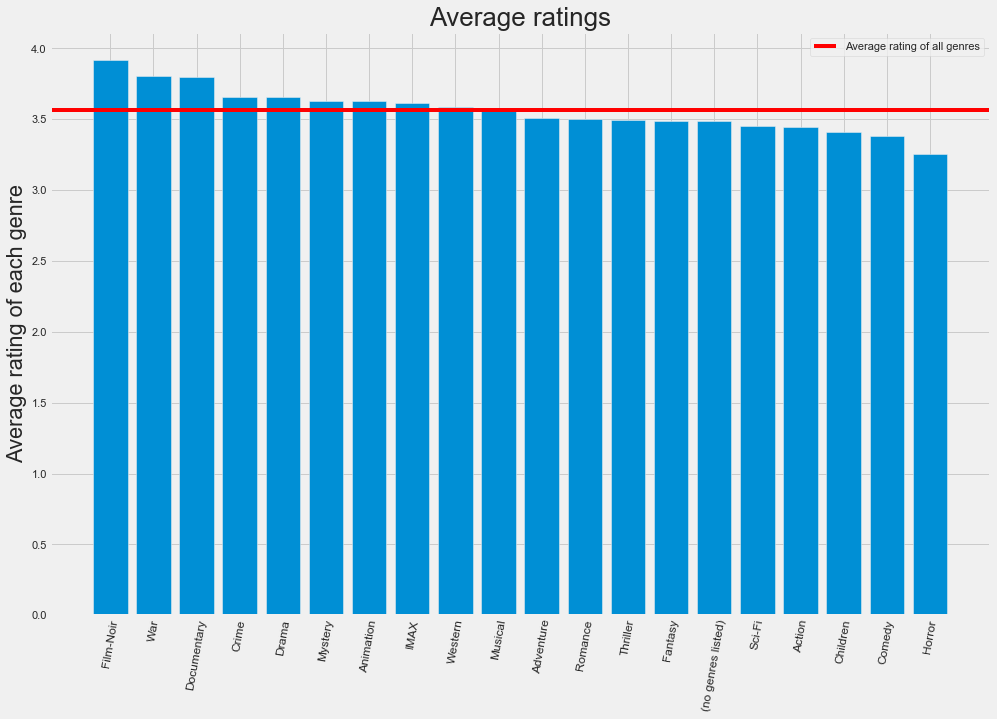

In [33]:
plt.style.use('fivethirtyeight')
plt.rcParams.update({'font.size': 18})


fig, ax = plt.subplots(figsize=(15,10))

ax.bar(genres_mean_df["Genre"],genres_mean_df["Mean"])
ax.axhline(genres_mean_df["Mean"].mean(), color="red", label="Average rating of all genres")

ax.set_xticklabels(genres_mean_df["Genre"], rotation=80, fontsize=12)

ax.set_ylabel("Average rating of each genre")
ax.set_title('Average ratings')
ax.legend()

plt.show()

*Observations:*
    
Film-Noir genre has the highest rating of all genres followed by War, Documentary and Crime. Comedy and Horror are the last placers.

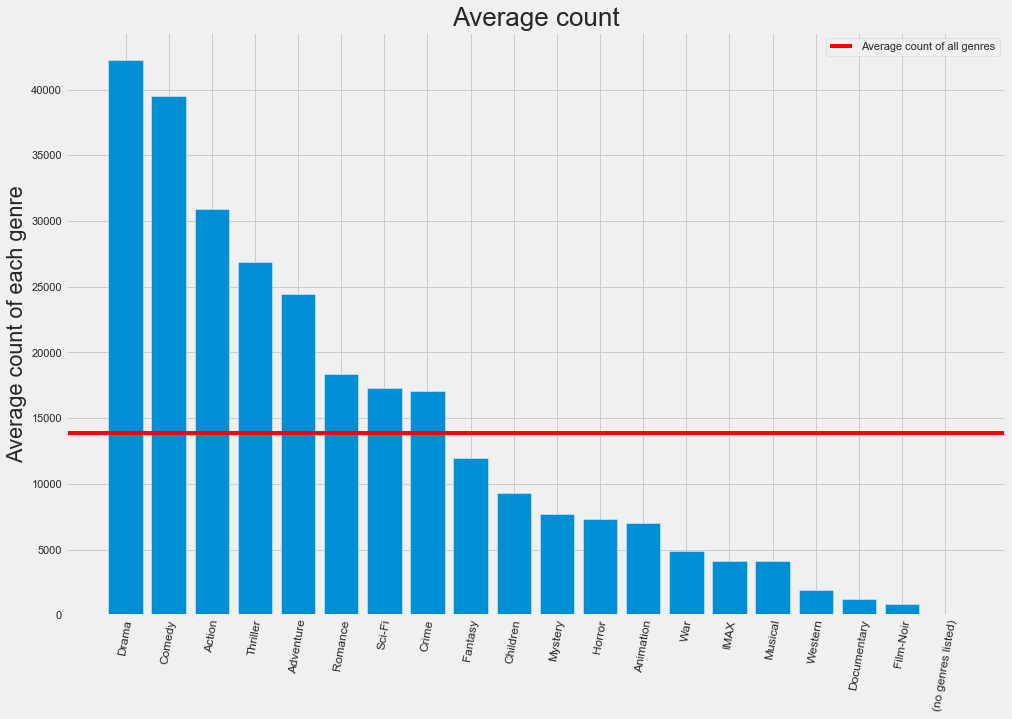

In [34]:
genres_mean_df = genres_mean_df.sort_values("Count", ascending=False)

plt.style.use('fivethirtyeight')
plt.rcParams.update({'font.size': 18})


fig, ax = plt.subplots(figsize=(15,10))

ax.bar(genres_mean_df["Genre"],genres_mean_df["Count"])
ax.axhline(genres_mean_df["Count"].mean(), color="red", label="Average count of all genres")

ax.set_xticklabels(genres_mean_df["Genre"], rotation=80, fontsize=12)

ax.set_ylabel("Average count of each genre")
ax.set_title('Average count')
ax.legend()

plt.show()

*Observations:*

There are many more Drama movies reviewed versus other genres. The highest-reviewed genre has one of the fewest movies reviewed. Although not many people seem to watch or review Film-Noir movies they are very well regarded. This strikes us as a type of film we might want to be reccommending to people who are not discovering them on their own.

### Year

In [35]:
date = []
for i in tqdm(df['timestamp']):
    date.append(datetime.datetime.fromtimestamp(i).strftime('%Y'))

In [36]:
df['ratedYear'] = date
df.shape

(101951, 10)

In [37]:
z = df['ratedYear'].value_counts()
ycounts = z.iloc[:]
years = z.index[:]

In [38]:
year_df = pd.DataFrame({'Year':years,'counts':ycounts})
year_df.reset_index(drop =True)
year_df.sort_values(by=['Year'],inplace = True)

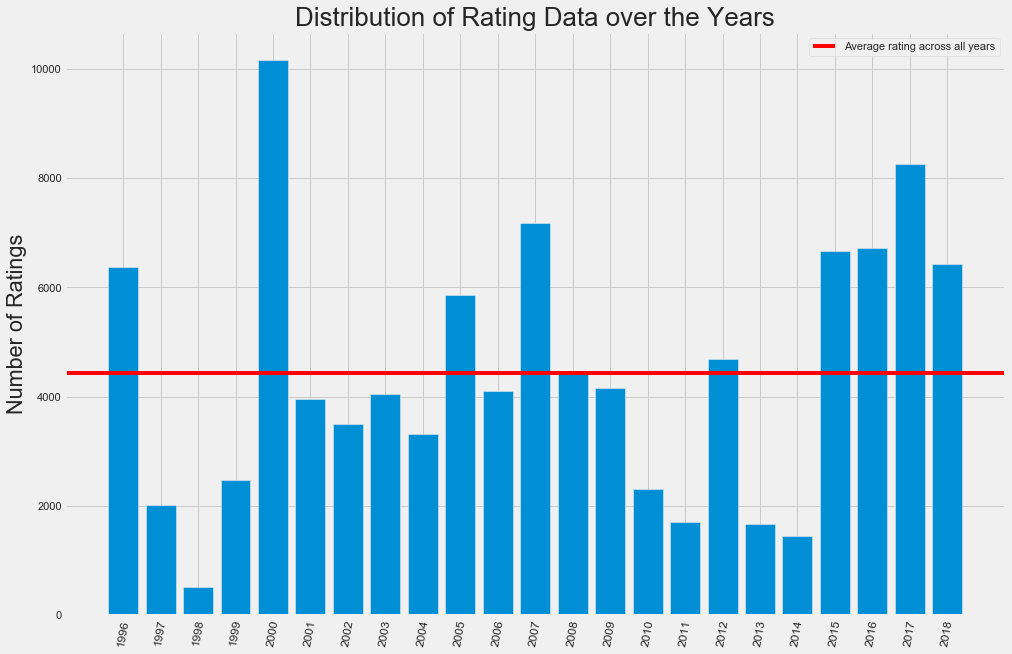

In [39]:
plt.style.use('fivethirtyeight')
plt.rcParams.update({'font.size': 18})


fig, ax = plt.subplots(figsize=(15,10))

ax.bar(year_df.Year,year_df.counts )
ax.axhline(year_df.counts.mean(), color="red", label="Average rating across all years")

ax.set_xticklabels(year_df.Year, rotation=80, fontsize=12)

ax.set_ylabel("Number of Ratings")
ax.set_title("Distribution of Rating Data over the Years")
ax.legend()

plt.show()

*Observations:*

In this particular sample of dataset provided from Movielens, we see a sudden resurgence in the number of available ratings beginning from the year 2015.

### Popularity Index

In [40]:
pc = df['movieId'].value_counts()[:1000]
xax = list(range(0,1000))

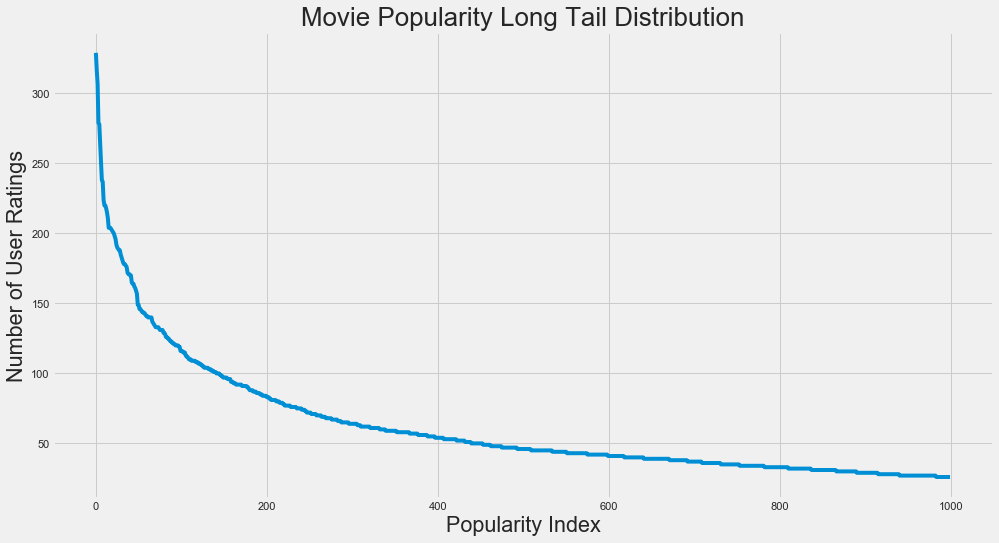

In [41]:
plt.figure(figsize=(15,8))
plt.plot(xax, pc)
plt.xlabel('Popularity Index')
plt.ylabel('Number of User Ratings')
plt.title('Movie Popularity Long Tail Distribution')
plt.show()

*Observations:*

The Popularity of Movies follow the long tail distibution which exemplifies the phenomenon of rich gets richer. More Popular movies get more ratings.

The need for Recommender Systems are represented by a concept called the "Long Tail," which is visualized in the figure above. In the context of movies, there are some movies that everyone is going to watch: A-list movies, superheroes etc. There are also movies that are far more obscure: indies and foreign films, low budget flicks etc. Recommendation systems are made to help consumers tap into this long tail to assist them in picking from the endless number of options that are made available to them via the internet.

### Plot EDA
We downloaded plot summaries for all of our films and will take a look at what we find in them here

In [42]:
#Download toolkits
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/carymosley/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/carymosley/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [43]:
#Create stop words
stop_words_ = set(stopwords.words('english'))
wn = WordNetLemmatizer()

In [44]:
def black_txt(token):
    '''This function removes tokens that are in our stop words and punctuation'''
    return  token not in stop_words_ and token not in list(string.punctuation)  and len(token)>2   
  
def clean_txt(text):
    '''This function cleans our text'''
    clean_text = []
    clean_text2 = []
    text = re.sub("'", "",text)
    text=re.sub("(\\d|\\W)+"," ",text) 
    text = text.replace("nbsp", "")
    clean_text = [ wn.lemmatize(word, pos="v") for word in word_tokenize(text.lower()) if black_txt(word)]
    clean_text2 = [word for word in clean_text if black_txt(word)]
    return " ".join(clean_text2)

In [45]:
nlp_df['plot'] = nlp_df['plot'].astype(str)
nlp_df['plot'] = nlp_df['plot'].apply(clean_txt)

In [46]:
#Looking at our dataframe
nlp_df.head()

,movieId,title,genres,imdbId,tmdbId,plot
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,114709,862.0,lead woody andys toy live happily room andys b...
1,2,Jumanji (1995),Adventure|Children|Fantasy,113497,8844.0,siblings judy peter discover enchant board gam...
3,3,Grumpier Old Men (1995),Comedy|Romance,113228,15602.0,family wed reignite ancient feud next door nei...
5,4,Waiting to Exhale (1995),Comedy|Drama|Romance,114885,31357.0,cheat mistreat step women hold breath wait elu...
7,5,Father of the Bride Part II (1995),Comedy,113041,11862.0,george bank recover daughters wed receive news...


In [47]:
nlp_df['plot'] = nlp_df['plot'].fillna("not applicable")

Now lets make some wordclouds from the plot of the movies for 4 star or higher, average films, and below 2.75 star ratings!

In [48]:
word_cloud_df=nlp_df.merge(ratings_df.groupby('movieId')['rating'].mean(),how='left',on='movieId')
word_cloud_df.head()

,movieId,title,genres,imdbId,tmdbId,plot,rating
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,114709,862.0,lead woody andys toy live happily room andys b...,3.920930
1,2,Jumanji (1995),Adventure|Children|Fantasy,113497,8844.0,siblings judy peter discover enchant board gam...,3.431818
2,3,Grumpier Old Men (1995),Comedy|Romance,113228,15602.0,family wed reignite ancient feud next door nei...,3.259615
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,114885,31357.0,cheat mistreat step women hold breath wait elu...,2.357143
4,5,Father of the Bride Part II (1995),Comedy,113041,11862.0,george bank recover daughters wed receive news...,3.071429


In [49]:
#Splitting the dataframes into top movies with a ranking of 4.5 or higher
#low rated movies with average rating 2.5 or lower and average movies

low_df = word_cloud_df[word_cloud_df['rating'] <= 2.75]
top_df = word_cloud_df[word_cloud_df['rating'] >= 4]
avg_df = word_cloud_df[word_cloud_df['rating']>2.75]
avg_df =avg_df[avg_df['rating'] < 4]
low = " ".join(plot for plot in low_df['plot'])
top = " ".join(plot for plot in top_df['plot'])
avg = " ".join(plot for plot in avg_df['plot'])

Checking the sizes of the rankings bucket

In [50]:
print('There are', top_df.shape[0], 'top films')
print('There are', low_df.shape[0], 'low rated films')
print('There are', avg_df.shape[0], 'average films')

There are 2270 top films
There are 2391 low rated films
There are 5063 average films


In [66]:
def wordcloud(text,colormap='Blues',interpolation = 'bilinear'):
    '''This function takes in text and outputs a wordcloud. Option
    arguments are colormap and interpolation '''
    wordcloud = WordCloud(width=1080, height=720, colormap=colormap).generate(text)
    plt.figure()
    plt.imshow(wordcloud, interpolation=interpolation)
    plt.axis("off")
    plt.margins(x=0, y=0)
    plt.show()

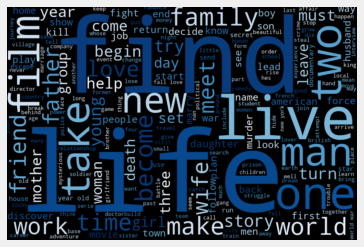

In [67]:
#Top rated wordcloud
wordcloud(top)

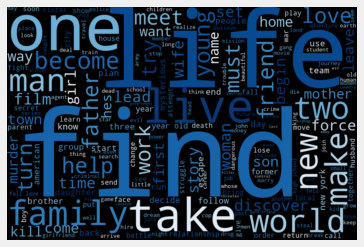

In [68]:
#Average rated wordcloud
wordcloud(avg)

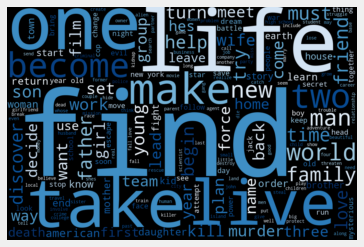

In [69]:
#Low rated wordcloud
wordcloud(low)

Looking at the wordclouds it seems like many of the words are the same across the ratings buckets. It is likely that our classification models will do a poor job if the words are similar.

## Train Test Split Data

In [70]:
df.columns

Index(['userId', 'movieId', 'rating', 'timestamp', 'title', 'genres', 'imdbId',
       'tmdbId', 'plot', 'ratedYear'],
      dtype='object')

In [71]:
#ratings_df.drop(columns='timestamp',inplace=True)
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(df[['userId','title','rating']], reader)
trainset, testset = surprise.model_selection.train_test_split(data, test_size=.25, random_state=42)

## Collaborative Filtering

### Item-Item Filtering


The Pivot table created below is used to map 1:1 relationship between movies, users and their ratings. By default, the pivot_table method takes average if there are multiple values of one combination.

In [72]:
ratings_matrix_items = ratings_df.pivot_table(index=['movieId'],columns=['userId'],values='rating').reset_index(drop=True)
ratings_matrix_items.fillna(0, inplace = True )
ratings_matrix_items.shape

(9724, 610)

In [73]:
ratings_matrix_items

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
0,4.0,0.0,0.0,0.0,4.0,0.0,4.5,0.0,0.0,0.0,...,4.0,0.0,4.0,3.0,4.0,2.5,4.0,2.5,3.0,5.0
1,0.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,0.0,0.0,...,0.0,4.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0,0.0
2,4.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9719,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9720,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9721,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9722,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [74]:
movie_similarity = 1 - pairwise_distances( ratings_matrix_items.as_matrix(), metric="cosine" )
np.fill_diagonal( movie_similarity, 0 ) 
ratings_matrix_items = pd.DataFrame( movie_similarity )
collab_matrix = ratings_matrix_items
ratings_matrix_items

,0,1,2,3,4,5,6,7,8,9,...,9714,9715,9716,9717,9718,9719,9720,9721,9722,9723
0,0.000000,0.410562,0.296917,0.035573,0.308762,0.376316,0.277491,0.131629,0.232586,0.395573,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.410562,0.000000,0.282438,0.106415,0.287795,0.297009,0.228576,0.172498,0.044835,0.417693,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.296917,0.282438,0.000000,0.092406,0.417802,0.284257,0.402831,0.313434,0.304840,0.242954,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.035573,0.106415,0.092406,0.000000,0.188376,0.089685,0.275035,0.158022,0.000000,0.095598,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.308762,0.287795,0.417802,0.188376,0.000000,0.298969,0.474002,0.283523,0.335058,0.218061,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9719,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0
9720,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0
9721,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0
9722,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0


In [75]:
ratings_matrix_items['movie'] = movies_df['title']
ratings_matrix_items.set_index('movie', inplace = True)


In [76]:
ratings_matrix_items.head(5)

,0,1,2,3,4,5,6,7,8,9,...,9714,9715,9716,9717,9718,9719,9720,9721,9722,9723
movie,,,,,,,,,,,,,,,,,,,,,
Toy Story (1995),0.000000,0.410562,0.296917,0.035573,0.308762,0.376316,0.277491,0.131629,0.232586,0.395573,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Jumanji (1995),0.410562,0.000000,0.282438,0.106415,0.287795,0.297009,0.228576,0.172498,0.044835,0.417693,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Grumpier Old Men (1995),0.296917,0.282438,0.000000,0.092406,0.417802,0.284257,0.402831,0.313434,0.304840,0.242954,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Waiting to Exhale (1995),0.035573,0.106415,0.092406,0.000000,0.188376,0.089685,0.275035,0.158022,0.000000,0.095598,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Father of the Bride Part II (1995),0.308762,0.287795,0.417802,0.188376,0.000000,0.298969,0.474002,0.283523,0.335058,0.218061,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [77]:
ratings_matrix_items.columns = ratings_matrix_items.index
ratings_matrix_items

movie,Toy Story (1995),Jumanji (1995),Grumpier Old Men (1995),Waiting to Exhale (1995),Father of the Bride Part II (1995),Heat (1995),Sabrina (1995),Tom and Huck (1995),Sudden Death (1995),GoldenEye (1995),...,Dogman (2018),Mamma Mia: Here We Go Again! (2018),Tag (2018),The Man Who Killed Don Quixote (2018),Boundaries (2018),Spiral (2018),Mission: Impossible - Fallout (2018),SuperFly (2018),Iron Soldier (2010),BlacKkKlansman (2018)
movie,,,,,,,,,,,,,,,,,,,,,
Toy Story (1995),0.000000,0.410562,0.296917,0.035573,0.308762,0.376316,0.277491,0.131629,0.232586,0.395573,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Jumanji (1995),0.410562,0.000000,0.282438,0.106415,0.287795,0.297009,0.228576,0.172498,0.044835,0.417693,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Grumpier Old Men (1995),0.296917,0.282438,0.000000,0.092406,0.417802,0.284257,0.402831,0.313434,0.304840,0.242954,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Waiting to Exhale (1995),0.035573,0.106415,0.092406,0.000000,0.188376,0.089685,0.275035,0.158022,0.000000,0.095598,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Father of the Bride Part II (1995),0.308762,0.287795,0.417802,0.188376,0.000000,0.298969,0.474002,0.283523,0.335058,0.218061,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Spiral (2018),0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0
Mission: Impossible - Fallout (2018),0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0
SuperFly (2018),0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0


In [78]:
ratings_matrix_items.iloc[9].sort_values(ascending=False).head(6)

movie
Die Hard: With a Vengeance (1995)    0.615794
True Lies (1994)                     0.576175
Clear and Present Danger (1994)      0.573650
Speed (1994)                         0.571704
Batman (1989)                        0.563148
Stargate (1994)                      0.562580
Name: GoldenEye (1995), dtype: float64

In [79]:
# create a box to let user input movie name (need a space after book name)
user_movie = str(input("Give a movie name?"))

Give a movie name?


In [80]:
# create a function to return top 5 recommendations based on given movie
def get_rec(user_movie,ratings_matrix_items):
    for i in ratings_matrix_items.index:
        if user_movie == i:
            return ratings_matrix_items[user_movie].sort_values(ascending= False)[1:6]

In [81]:
# show recommendation results
print('Top 5 movie recommendations for you:')
print(get_rec(user_movie,ratings_matrix_items))

Top 5 movie recommendations for you:
None


#### Evaluation

In [84]:
# Try two similarity metrics
sim_pear = {'name':'pearson','user_based':False}
sim_cos = {'name':'cosine','user_based':False}

# Fit the model using KNN 
basic = knns.KNNBasic(sim_options=sim_cos)
basic.fit(trainset)
predictions_knn = basic.test(testset)
print(accuracy.rmse(predictions_knn))

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.9754
0.9753547688025954


In [85]:
# Fit the model using KNN 
basic = knns.KNNBasic(sim_options=sim_pear)
basic.fit(trainset)
predictions_knn = basic.test(testset)
print(accuracy.rmse(predictions_knn))

Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.9709
0.9708690766611539


### User-User Filtering

In this method, we recommend movies to a user based on his preferences compared to preferences of other users. This algorithm is very effective but takes a lot of time and resources. 

In [86]:
ratings_matrix_users = df.pivot_table(index=['userId'],columns=['movieId'],values='rating').reset_index(drop=True)
ratings_matrix_users.fillna( 0, inplace = True )
movie_similarity = 1 - pairwise_distances( ratings_matrix_users.as_matrix(), metric="cosine" )
np.fill_diagonal( movie_similarity, 0 ) #Filling diagonals with 0s for future use when sorting is done
ratings_matrix_users = pd.DataFrame( movie_similarity )
ratings_matrix_users

,0,1,2,3,4,5,6,7,8,9,...,600,601,602,603,604,605,606,607,608,609
0,0.000000,0.027283,0.059720,0.194395,0.129080,0.128152,0.158744,0.136968,0.064263,0.016875,...,0.080554,0.164455,0.221486,0.070669,0.153625,0.164191,0.269389,0.291097,0.093572,0.145321
1,0.027283,0.000000,0.000000,0.003726,0.016614,0.025333,0.027585,0.027257,0.000000,0.067445,...,0.202671,0.016866,0.011997,0.000000,0.000000,0.028429,0.012948,0.046211,0.027565,0.102427
2,0.059720,0.000000,0.000000,0.002251,0.005020,0.003936,0.000000,0.004941,0.000000,0.000000,...,0.005048,0.004892,0.024992,0.000000,0.010694,0.012993,0.019247,0.021128,0.000000,0.032119
3,0.194395,0.003726,0.002251,0.000000,0.128659,0.088491,0.115120,0.062969,0.011361,0.031163,...,0.085938,0.128273,0.307973,0.052985,0.084584,0.200395,0.131746,0.149858,0.032198,0.107683
4,0.129080,0.016614,0.005020,0.128659,0.000000,0.300349,0.108342,0.429075,0.000000,0.030611,...,0.068048,0.418747,0.110148,0.258773,0.148758,0.106435,0.152866,0.135535,0.261232,0.060792
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
605,0.164191,0.028429,0.012993,0.200395,0.106435,0.102123,0.200035,0.099388,0.075898,0.088963,...,0.178084,0.116534,0.300669,0.066032,0.148141,0.000000,0.153063,0.262558,0.069622,0.201104
606,0.269389,0.012948,0.019247,0.131746,0.152866,0.162182,0.186114,0.185142,0.011844,0.010451,...,0.092525,0.199910,0.203540,0.137834,0.118780,0.153063,0.000000,0.283081,0.149190,0.139114
607,0.291097,0.046211,0.021128,0.149858,0.135535,0.178809,0.323541,0.187233,0.100435,0.077424,...,0.158355,0.197514,0.232771,0.155306,0.178142,0.262558,0.283081,0.000000,0.121993,0.322055
608,0.093572,0.027565,0.000000,0.032198,0.261232,0.214234,0.090840,0.423993,0.000000,0.021766,...,0.035653,0.335231,0.061941,0.236601,0.097610,0.069622,0.149190,0.121993,0.000000,0.053225



Here now we have similarity of users in colums with respective users in row. So if we find maximum value in a column we will get the user with highest similarity. So now we can have a pair of users which are similar.

In [87]:
ratings_matrix_users.idxmax(axis=1)

0      265
1      365
2      312
3      390
4      469
      ... 
605    473
606    569
607    479
608    339
609    248
Length: 610, dtype: int64

In [88]:
ratings_matrix_users.idxmax(axis=1).sample( 10, random_state = 42)

81     437
218    238
55      93
598    413
264    201
155    274
482     67
321    329
580    299
291     20
dtype: int64

In [89]:
similar_user_series= ratings_matrix_users.idxmax(axis=1)
df_similar_user= similar_user_series.to_frame()
df_similar_user.columns=['similarUser']
df_similar_user.head(5)

,similarUser
0,265
1,365
2,312
3,390
4,469


The function belows takes in a user id then looks at the similarUser dataframe to check the most similar user. Then this automatically outputs n recommendations that are highly-rated by the similar user.

In [90]:
def similar_user_rec(user_id,n=5):
    '''The function belows takes in a user id then looks at the similarUser dataframe to check the most similar user. Then this automatically outputs five recommendations that are highly-rated by the similar user.'''
    similar_user = df_similar_user['similarUser'].iloc[user_id]
    new_df = df.loc[(df['userId'] == similar_user)]
    new_df = new_df.sort_values('rating', ascending=False).head(n)
    rec_list = new_df['title'].to_list()
    print("Based on users with similar tastes, you will also like the following movies:")
    return rec_list[0:n+1]

In [92]:
similar_user_rec(581,10)

Based on users with similar tastes, you will also like the following movies:


['Immortals (2011)',
 'Watchmen (2009)',
 'Lord of the Rings: The Return of the King, The (2003)',
 'Matrix Revolutions, The (2003)',
 'Pirates of the Caribbean: The Curse of the Black Pearl (2003)',
 'Lord of the Rings: The Two Towers, The (2002)',
 'Mulholland Drive (2001)',
 'Spirited Away (Sen to Chihiro no kamikakushi) (2001)',
 'Lord of the Rings: The Fellowship of the Ring, The (2001)',
 'Gosford Park (2001)']

#### Evaluation

In [93]:
# Try two similarity metrics
sim_pear = {'name':'pearson','user_based':True}
sim_cos = {'name':'cosine','user_based':True}

# Fit the model using KNN 
basic = knns.KNNBasic(sim_options=sim_cos)
basic.fit(trainset)
predictions_knn = basic.test(testset)
print(accuracy.rmse(predictions_knn))

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.9764
0.9763937746323682


In [94]:
# Fit the model using KNN 
basic = knns.KNNBasic(sim_options=sim_pear)
basic.fit(trainset)
predictions_knn = basic.test(testset)
print(accuracy.rmse(predictions_knn))

Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.9774
0.977433834462353


### Memory-Based Methods (Neighborhood-Based)

The first thing we are going to do is build some baseline Collaborative Recommendation models. We will begin with Surprise and loading in our data. We'll first look at RMSE for evaluation but then expand to a hit rate metric.

In [95]:
ratings_df.drop(columns='timestamp',inplace=True)
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(ratings_df, reader)

Let's look at how many users and items we have in our dataset.

In [96]:
dataset = data.build_full_trainset()
print('Number of users: ', dataset.n_users, '\n')
print('Number of items: ', dataset.n_items)

Number of users:  610 

Number of items:  9724


In [100]:
#Creating SVD Model and showing RMSE
params = {'n_epochs': [5,10,20],
          'n_factors': [20, 50, 100],
         'reg_all': [0.02, 0.05, 0.1]}
g_s_svd = GridSearchCV(SVD,param_grid=params,n_jobs=1)
g_s_svd.fit(data)
print(g_s_svd.best_score)
print(g_s_svd.best_params)


{'rmse': 0.869141571025615, 'mae': 0.6678707396684065}
{'rmse': {'n_epochs': 20, 'n_factors': 100, 'reg_all': 0.05}, 'mae': {'n_epochs': 20, 'n_factors': 100, 'reg_all': 0.05}}


The best SVD model for gridsearch resulted in an RMSE of 0.869 and a MAE of .67.

In [101]:
sim_metrics = ['pearson','MSD','cosine','pearson_baseline']
#Creating Basic KNN Model and showing RMSE, checking all distance metrics
for metric in sim_metrics:
    knn_basic = KNNBasic(sim_options={'name': metric, 'user_based':True})
    cv_knn_basic = cross_validate(knn_basic, data, n_jobs=-1)
    print('Similarity Metric = ', metric,'---', 'test_rmse = ', np.mean(cv_knn_basic['test_rmse']),'\n')
    
    

Similarity Metric =  pearson --- test_rmse =  0.9742431395222996 

Similarity Metric =  MSD --- test_rmse =  0.9468739244202145 

Similarity Metric =  cosine --- test_rmse =  0.9702745126120258 

Similarity Metric =  pearson_baseline --- test_rmse =  0.9719140128621817 



The basic KNN model performed worse than the SVD model across all similarity metrics

In [102]:
# cross validating with KNNBaseline
for metric in sim_metrics:
    knn_baseline = KNNBaseline(sim_options={'name':'pearson', 'user_based':True})
    cv_knn_baseline = cross_validate(knn_baseline,data)
    print('Similarity Metric = ', metric,'---', 'test_rmse = ', np.mean(cv_knn_baseline['test_rmse']),'\n')

Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Similarity Metric =  pearson --- test_rmse =  0.8768569912398219 

Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matri

The KNN Baseline model results in RMSE values are similar to the SVD  model so we will look at a hit rate method for evaluation.

#### Hit rate as an evaluation
The hit rate method for evaluation takes the set of model outputs and then predicts n movies that they will have rated. Everytime a predicted movie appears in the actual list we will mark it as a hit. We will look at this both by rating and cumulatively to evaluate our KNN and SVD models.

In [126]:
#Get top N predictions for ratings above minRating
def GetTopN(predictions, n=10, minRating=4.0):
    '''This function takes in model predictions, top n as an integer, and the minimum rating we care about and outputs the predicted topN entries'''
    topN = defaultdict(list)
    for userID, movieID, actualRating, estimatedRating, _ in predictions:
        if (estimatedRating >= minRating):
            topN[int(userID)].append((int(movieID), estimatedRating))

    for userID, ratings in topN.items():
        ratings.sort(key=lambda x: x[1], reverse=True)
        topN[int(userID)] = ratings[:n]

    return topN
    
LOOCV = LeaveOneOut(n_splits=1, random_state=1)



In [131]:
def RatingHitRate(topNPredicted, leftOutPredictions):
    '''Inputs the predicted n recs and the actual recs to calcualate hit rate by rating'''
    hits = defaultdict(float)
    total = defaultdict(float)
    # For each left-out rating
    for userID, leftOutMovieID, actualRating, estimatedRating, _ in leftOutPredictions:
        # Is it in the predicted top N for this user?
        hit = False
        for movieID, predictedRating in topNPredicted[int(userID)]:
            if (int(leftOutMovieID) == movieID):
                hit = True
                break
        if (hit) :
            hits[actualRating] += 1
        total[actualRating] += 1

    # Compute overall precision
    for rating in sorted(hits.keys()):
        print(rating, hits[rating] / total[rating])

In [127]:
#Split into train and test sets
trainSet, testSet = surprise.model_selection.train_test_split(data, test_size=.25, random_state=0)



In [111]:
#Get top predictions 
#When I use n=10 for knn it gets 0 hits, expanding to 50 it got a positive non-zero amount
#so I am confident it is working just doing a worse job likely due to sparseness. I expanded
#both to 50 for now
svd_model= SVD(n_factors=50,reg_all=0.05)
KNN_model= KNNBaseline(sim_options={'name':'pearson', 'user_based':True})

for trainSet, testSet in LOOCV.split(data):
    # Train model without left-out ratings
    svd_model.fit(trainSet)
    leftOutPredictionsSVD = svd_model.test(testSet)
    bigTestSet = trainSet.build_anti_testset()
    allPredictionsSVD = svd_model.test(bigTestSet)
    
    KNN_model.fit(trainSet)
    leftOutPredictionsKNN = KNN_model.test(testSet)
    bigTestSet = trainSet.build_anti_testset()
    allPredictionsKNN = KNN_model.test(bigTestSet)
   
  
  

Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.


In [128]:
n=50
minrating=2
# Compute top 50 recs for each user
topNPredictedSVD = GetTopN(allPredictionsSVD, n, minrating)
topNPredictedKNN = GetTopN(allPredictionsKNN, n, minrating)

In [129]:
print("Hit Rate by Rating value SVD: ")
RatingHitRate(topNPredictedSVD, leftOutPredictionsSVD)

Hit Rate by Rating value SVD: 
2.5 0.06666666666666667
3.0 0.034782608695652174
3.5 0.041666666666666664
4.0 0.10555555555555556
4.5 0.2830188679245283
5.0 0.13821138211382114


In [130]:
print("Hit Rate by Rating value KNN: ")
RatingHitRate(topNPredictedKNN, leftOutPredictionsKNN)

Hit Rate by Rating value KNN: 
4.0 0.005555555555555556
5.0 0.008130081300813009


Its pretty clear that the SVD model is outperforming the KNN model here. It was slightly better using RMSE and is significantly better using a hit rate method. We will use the SVD model for the collaborative filtering portion of our hybrid model.

## Content-Based Filtering

In the resulting dataframe after running multiple API calls, we are able to get the plot of each movie. This section aims to build an accurate model that makes recommendation based on plot similarities.

### Bag of Words

Using our cleaned plot tokens we will create a bag of words count and use this to compute a cosine similarity matrix to recommend films

In [132]:
count = CountVectorizer()
count_matrix = count.fit_transform(nlp_df['plot'])
cosine_sim = cosine_similarity(count_matrix, count_matrix)
print(cosine_sim)

[[1.         0.04222003 0.         ... 0.         0.02401461 0.        ]
 [0.04222003 1.         0.04767313 ... 0.         0.02585438 0.02132007]
 [0.         0.04767313 1.         ... 0.05270463 0.         0.04472136]
 ...
 [0.         0.         0.05270463 ... 1.         0.         0.        ]
 [0.02401461 0.02585438 0.         ... 0.         1.         0.02425356]
 [0.         0.02132007 0.04472136 ... 0.         0.02425356 1.        ]]


In [133]:
count_matrix.shape

(9742, 25579)

In [134]:
indices = pd.Series(nlp_df['title'])

In [139]:
def recommend(title,n=5, cosine_sim = cosine_sim):
    '''This function takes in a title and number n and outputs n recommendations '''
    recommended_movies = []
    idx = indices[indices == title].index[0]
    score_series = pd.Series(cosine_sim[idx]).sort_values(ascending = False)
    top_n_indices = list(score_series.iloc[1:n+1].index)
    
    for i in top_n_indices:
        recommended_movies.append(list(nlp_df['title'])[i])
        
    return recommended_movies

In [141]:
n=10
recommend('Batman (1989)',n)

['Crossfire (1947)',
 'Munich (2005)',
 'Blow-Out (La grande bouffe) (1973)',
 'Hills Have Eyes II, The (2007)',
 'Ski School (1991)',
 'Great Silence, The (Grande silenzio, Il) (1969)',
 'Femme Nikita, La (Nikita) (1990)',
 'To Sir with Love (1967)',
 'Speechless (1994)',
 'Dream Team, The (1989)']

### TF-IDF Models
In this section we will calculate TF_IDF and then use various models to see whether we can accurately classify movies into their potental ratings bucket. Note that in the Plot EDA section we show where we created the buckets

Now we will build some classification models to see if they can group the ratings into the top, low, and average categories

In [146]:
#convert into categories
word_cloud_df['category'] = word_cloud_df['rating'].apply(lambda x: 'top' if x>=4.5 else ('low' if x<=2.5 else 'avg'))



In [147]:
word_cloud_df.head()

,movieId,title,genres,imdbId,tmdbId,plot,rating,category
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,114709,862.0,lead woody andys toy live happily room andys b...,3.920930,avg
1,2,Jumanji (1995),Adventure|Children|Fantasy,113497,8844.0,siblings judy peter discover enchant board gam...,3.431818,avg
2,3,Grumpier Old Men (1995),Comedy|Romance,113228,15602.0,family wed reignite ancient feud next door nei...,3.259615,avg
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,114885,31357.0,cheat mistreat step women hold breath wait elu...,2.357143,low
4,5,Father of the Bride Part II (1995),Comedy,113041,11862.0,george bank recover daughters wed receive news...,3.071429,avg


In [148]:
#use plot as the features, category as the output
X = word_cloud_df['plot']
y = word_cloud_df['category']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 13)

categories = ['top', 'avg', 'low']


First we will make a naive bayes classifier

In [149]:
nb = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
              ])
nb.fit(X_train, y_train)

y_pred = nb.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=categories))
print(pd.Series(y_pred).value_counts())

accuracy 0.7152385838891739
              precision    recall  f1-score   support

         top       0.72      1.00      0.83      1394
         avg       0.00      0.00      0.00       403
         low       0.00      0.00      0.00       152

    accuracy                           0.72      1949
   macro avg       0.24      0.33      0.28      1949
weighted avg       0.51      0.72      0.60      1949

avg    1949
dtype: int64


In [150]:
confusion_matrix(y_test, y_pred, labels=categories)

array([[   0,  152,    0],
       [   0, 1394,    0],
       [   0,  403,    0]])

The naive bayes classifier simply labeled everything as average. Not a good outcome. Next we'll try a logistic regression classifier.

In [151]:

logreg = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(C=1e5)),
               ])
logreg.fit(X_train, y_train)


y_pred = logreg.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=categories))
print(pd.Series(y_pred).value_counts())

accuracy 0.6331452026680349
              precision    recall  f1-score   support

         top       0.73      0.81      0.77      1394
         avg       0.27      0.23      0.25       403
         low       0.21      0.09      0.12       152

    accuracy                           0.63      1949
   macro avg       0.40      0.38      0.38      1949
weighted avg       0.60      0.63      0.61      1949

avg    1537
low     349
top      63
dtype: int64


In [152]:
confusion_matrix(y_test, y_pred, labels=categories)

array([[  13,  116,   23],
       [  33, 1128,  233],
       [  17,  293,   93]])

The logistic had a the highest overall accuracy by a small amount and it did classify into each of the ratings buckets! Finally, we'll look at a SGD classifier.

In [153]:
#SVG with SGD
sgd = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss='log', penalty='l2',alpha=.001, random_state=13, max_iter=1000)),
               ])
sgd.fit(X_train, y_train)

y_pred = sgd.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=categories))
print(pd.Series(y_pred).value_counts())

accuracy 0.7152385838891739
              precision    recall  f1-score   support

         top       0.72      1.00      0.83      1394
         avg       0.00      0.00      0.00       403
         low       0.00      0.00      0.00       152

    accuracy                           0.72      1949
   macro avg       0.24      0.33      0.28      1949
weighted avg       0.51      0.72      0.60      1949

avg    1949
dtype: int64


In [154]:
confusion_matrix(y_test, y_pred, labels=categories)

array([[   0,  152,    0],
       [   0, 1394,    0],
       [   0,  403,    0]])

We can see that the SVD and Naive Bayes models both simply classified everything as an average rating. The Logistic model performed better but still not great. It seems that using plot alone to differentiate the rating is not particularly helpful. Next we will look at a simple neural net model for classification into categories.




In [155]:
nn_df = nlp_df.merge(ratings_df)
nn_df.drop(columns=['imdbId','tmdbId','genres'],inplace=True)
nn_df.head()

,movieId,title,plot,userId,rating
0,1,Toy Story (1995),lead woody andys toy live happily room andys b...,1,4.0
1,1,Toy Story (1995),lead woody andys toy live happily room andys b...,5,4.0
2,1,Toy Story (1995),lead woody andys toy live happily room andys b...,7,4.5
3,1,Toy Story (1995),lead woody andys toy live happily room andys b...,15,2.5
4,1,Toy Story (1995),lead woody andys toy live happily room andys b...,17,4.5


In [159]:

# Raw text complaints
plot = word_cloud_df['plot'] 

# Initialize a tokenizer 
tokenizer = Tokenizer(num_words=20000) 

# Fit it to the complaints
tokenizer.fit_on_texts(plot) 

# Generate sequences
sequences = tokenizer.texts_to_sequences(plot) 
print('sequences type:', type(sequences))

# Similar to sequences, but returns a numpy array
one_hot_results= tokenizer.texts_to_matrix(plot, mode='binary') 
print('one_hot_results type:', type(one_hot_results))

# Useful if we wish to decode (more explanation below)
word_index = tokenizer.word_index 

# Tokens are the number of unique words across the corpus
print('Found %s unique tokens.' % len(word_index)) 

# Our coded data
print('Dimensions of our coded results:', np.shape(one_hot_results)) 

sequences type: <class 'list'>
one_hot_results type: <class 'numpy.ndarray'>
Found 25574 unique tokens.
Dimensions of our coded results: (9742, 20000)


In [160]:
reverse_index = dict([(value, key) for (key, value) in word_index.items()])

In [161]:
rating = word_cloud_df['category']

# Initialize
le = preprocessing.LabelEncoder() 
le.fit(rating)
print('Original class labels:')
print(list(le.classes_))
print('\n')
rating_cat = le.transform(rating)  

# If you wish to retrieve the original descriptive labels post production
# list(le.inverse_transform([0, 1, 3, 3, 0, 6, 4])) 

print('New rating labels:')
print(rating_cat)
print('\n')

# Each row will be all zeros except for the category for that observation 
print('One hot labels; 3 class columns, one for each of the categories.') 
rating_onehot = to_categorical(rating_cat)
print(rating_onehot)
print('\n')

print('One hot labels shape:')
print(np.shape(rating_onehot))

Original class labels:
['avg', 'low', 'top']


New rating labels:
[0 0 0 ... 0 0 0]


One hot labels; 3 class columns, one for each of the categories.
[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 ...
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]


One hot labels shape:
(9742, 3)


In [162]:
random.seed(13)
test_index = random.sample(range(1,9742), 1500)

test = one_hot_results[test_index]
train = np.delete(one_hot_results, test_index, 0)

label_test = rating_onehot[test_index]
label_train = np.delete(rating_onehot, test_index, 0)

print('Test label shape:', np.shape(label_test))
print('Train label shape:', np.shape(label_train))
print('Test shape:', np.shape(test))
print('Train shape:', np.shape(train))

Test label shape: (1500, 3)
Train label shape: (8242, 3)
Test shape: (1500, 20000)
Train shape: (8242, 20000)


In [163]:
# Initialize a sequential model
model = models.Sequential()

# Two layers with relu activation
model.add(layers.Dense(50, activation='relu', input_shape=(20000,)))
model.add(layers.Dense(25, activation='relu'))

# One layer with softmax activation 
model.add(layers.Dense(3, activation='softmax'))
# Compile the model
model.compile(optimizer='SGD',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [164]:
# Train the model 
history = model.fit(train,
                    label_train,
                    epochs=20,
                    batch_size=256)

Epoch 1/20
8242/8242 [==============================] - 2s 200us/step - loss: 1.0606 - accuracy: 0.5465
Epoch 2/20
8242/8242 [==============================] - 1s 171us/step - loss: 0.9637 - accuracy: 0.7236
Epoch 3/20
8242/8242 [==============================] - 1s 171us/step - loss: 0.8868 - accuracy: 0.7236
Epoch 4/20
8242/8242 [==============================] - 1s 172us/step - loss: 0.8328 - accuracy: 0.7236
Epoch 5/20
8242/8242 [==============================] - 1s 171us/step - loss: 0.7983 - accuracy: 0.7236
Epoch 6/20
8242/8242 [==============================] - 1s 172us/step - loss: 0.7769 - accuracy: 0.7236
Epoch 7/20
8242/8242 [==============================] - 1s 172us/step - loss: 0.7647 - accuracy: 0.7236
Epoch 8/20
8242/8242 [==============================] - 1s 174us/step - loss: 0.7574 - accuracy: 0.7236
Epoch 9/20
8242/8242 [==============================] - 1s 173us/step - loss: 0.7531 - accuracy: 0.7236
Epoch 10/20
8242/8242 [==============================] - 1s 173u

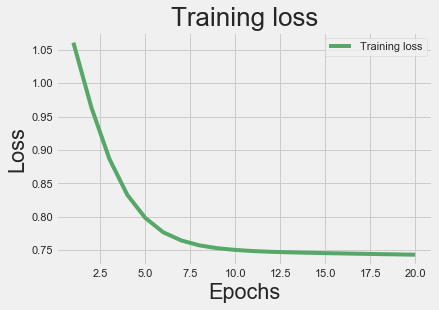

In [165]:
history_dict = history.history
loss_values = history_dict['loss']

epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, 'g', label='Training loss')

plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

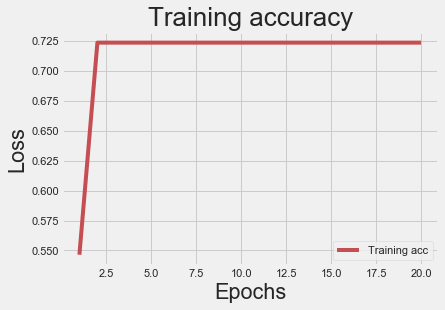

In [166]:
# Plot the training accuracy vs the number of epochs

acc_values = history_dict['accuracy'] 

plt.plot(epochs, acc_values, 'r', label='Training acc')
plt.title('Training accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [167]:
# Output (probability) predictions for the test set 
y_pred = model.predict(test) 
y_labels = model.predict_classes(test)
# Print the loss and accuracy for the training set 
results_train = model.evaluate(train, label_train)
results_train

8242/8242 [==============================] - 1s 70us/step


[0.7429767210950438, 0.7236107587814331]

In [168]:
# Print the loss and accuracy for the test set 
results_test = model.evaluate(test, label_test)
results_test

1500/1500 [==============================] - 0s 65us/step


[0.7721532096862793, 0.7080000042915344]

In [169]:
y_pred

array([[0.7208846 , 0.20063058, 0.0784848 ],
       [0.7211885 , 0.19991772, 0.07889371],
       [0.7332675 , 0.19344087, 0.07329158],
       ...,
       [0.7471384 , 0.18807591, 0.06478576],
       [0.7040034 , 0.21050778, 0.08548883],
       [0.7104487 , 0.20608218, 0.08346911]], dtype=float32)

In [170]:
y_labels

array([0, 0, 0, ..., 0, 0, 0])

We can see that this neural net model classified every film into the average category which is the same output as the Naive Bayes and SDG. I think we can definitely say that the plot is not a useful feature for predicting movie rating. We can still use plot as a similarity but it is not useful for prediciting the movie rating.

### Content-Based recommendations based on plot similiarity using TF-IDF

In [182]:
#Create a tf-idf vectorizer using unigrams and bi-grams
#As we have already cleaned the data we don't need stop works here
tf = TfidfVectorizer(analyzer='word', ngram_range=(1, 2))
tfidf_matrix = tf.fit_transform(word_cloud_df['plot'])

In [183]:
#We get the cosine similarity matrix using the sklearn linear_kernal module
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)
content_matrix = cosine_sim

In [184]:
tfidf_matrix.shape

(9742, 243934)

In [217]:
content_matrix.shape

(9742, 9742)

In [186]:
df.head()

,userId,movieId,rating,timestamp,title,genres,imdbId,tmdbId,plot,ratedYear
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,114709,862.0,"Led by Woody, Andy's toys live happily in his ...",2000
1,5,1,4.0,847434962,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,114709,862.0,"Led by Woody, Andy's toys live happily in his ...",1996
2,7,1,4.5,1106635946,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,114709,862.0,"Led by Woody, Andy's toys live happily in his ...",2005
3,15,1,2.5,1510577970,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,114709,862.0,"Led by Woody, Andy's toys live happily in his ...",2017
4,17,1,4.5,1305696483,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,114709,862.0,"Led by Woody, Andy's toys live happily in his ...",2011


In [187]:
#using just the items we care about here
titles = word_cloud_df[['title','genres', 'plot', 'rating']]
indices = pd.Series(word_cloud_df.index, index=word_cloud_df['title'])

### Content Rec
Below we will make recommendations based on similar plots from our film database.

In [218]:
def content_recommendations(title,n):
    '''This function takes in a title and a number of recs and outputs
    the number of closests films based on plot similarity'''
    idx = indices[title]
    sim_scores = list(enumerate(content_matrix[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:n+1]
    movies = [i[0] for i in sim_scores]
    return titles.iloc[movies].sort_values('rating', ascending=False)

In [219]:
content_recommendations('Jumanji (1995)',15)

,title,genres,plot,rating
5604,Nirvana (1997),Action|Sci-Fi,jimi computer game designer find latest produc...,4.500000
5133,Night of the Living Dead (1990),Horror,remake original classic film group people trap...,4.000000
1961,eXistenZ (1999),Action|Sci-Fi|Thriller,game designer run assassins must play latest v...,3.863636
4247,Poolhall Junkies (2002),Comedy|Drama|Thriller,retire pool hustler force pick stick brother s...,3.833333
9145,Doctor Who: Last Christmas (2014),Adventure|Drama|Fantasy|Sci-Fi,doctor clara face last christmas trap arctic b...,3.750000
8022,Wreck-It Ralph (2012),Animation|Comedy,wreck ralph foot tall pound villain arcade vid...,3.750000
1550,Peter Pan (1953),Animation|Children|Fantasy|Musical,leave safety nursery behind wendy michael john...,3.573171
5259,"Last Starfighter, The (1984)",Action|Adventure|Comedy|Sci-Fi,video game expert alex rogan find transport an...,3.571429
7132,Gamer (2009),Action|Sci-Fi|Thriller,mind control technology take society storm mul...,3.428571
8031,Indie Game: The Movie (2012),Documentary,follow dramatic journey video game developers ...,3.000000


## Hybrid Models

We opted to build several Hybrid Models that combines Collaborative and Content-Based approach in order for us to address two main issues:
1. Cold Start
2. Sparsity

Cold Start happens when there is new users or items so there is not enough data to make recommendations. Sparsity because the number of movies is extremely large and it is almost impossible for most users to review all of the movies. 

### Hybrid Model 1

Our Hybrid Model 1 works as follows:
- Our model will recommend n movies based on the plot of the movies
- Then our best-performing collaborative-filtering model will predict the ratings of the n movies and sort them accordingly

We need to inputs to get recommendations. First is his/her user id then a movie he/she really likes.

In [191]:
# rec_user_id = 150
# rec_fave_movie = "Gone with the Wind (1939)"

In [193]:
def hybrid_rec(userid, favemovie,n=10):
    '''this takes in a userid, favemovie and n number of recs and outputs those in a sorted list'''
    rec_hybrid = content_recommendations(favemovie,n)
    svd = SVD(n_factors=50, reg_all= 0.05)
    trainset = data.build_full_trainset()
    svd.fit(trainset)
    
    for index, row in rec_hybrid.iterrows():    
        pred = svd.predict(userid, index)
        rec_hybrid.at[index, 'score'] = pred.est
    rec_hybrid = rec_hybrid.sort_values('score', ascending=False)
    return rec_hybrid

In [195]:
hybrid_rec(150, "Godfather, The (1972)",n=15)

,title,genres,plot,rating,score
1228,"Assignment, The (1997)",Action|Thriller,jack shaw donald sutherland experience terror ...,5.000000,4.265917
922,"Godfather: Part II, The (1974)",Crime|Drama,continue saga corleone crime family young vito...,4.259690,4.241502
5873,"Amityville Horror, The (2005)",Horror|Thriller,hair raise remake horror hit depict ordeal lut...,2.250000,3.687247
3071,Jaws: The Revenge (1987),Horror|Thriller,another deadly shark attack ellen brody decide...,1.250000,3.681699
9541,The Godfather Trilogy: 1972-1990 (1992),(no genres listed),multigenerational saga rise fall corleone crim...,4.750000,3.564694
614,'Til There Was You (1997),Drama|Romance,two strangers whose paths always cross finally...,4.000000,3.564694
7697,Warrior (2011),Drama,youngest son alcoholic former boxer return hom...,3.727273,3.564694
2030,Summer of Sam (1999),Drama,spike lees take son sam murder new york city s...,3.400000,3.564694
3292,Made (2001),Comedy,two aspire boxers lifelong friends get involve...,2.666667,3.564694
8793,Run All Night (2015),Action|Crime|Drama|Thriller,brooklyn mobster prolific hit man jimmy conlon...,2.166667,3.564694


### Hybrid Model 2

Our Hybrid Model 2 works as follows:

- We have bucketed our movie list into four categories depending on its popularity 
- Popularity is calculated based on the number of reviews made on it
- Then we will aggregate cosine similarity scores of our content-based model (based on movie plot) and the best-performing collaborative-filtering model
- The aggregation of the similarity scores will depend on the popularity:
    - If very popular, 15% collaborative-filtering + 85% content-based
    - If popular, 25% collaborative-filtering + 75% content-based
    - If moderate, 35% collaborative-filtering + 65% content-based
    - If low, 50-50

In [209]:
pop_df = pd.merge(ratings_df,movies_df, on='movieId', how='left')

In [210]:
pop_df = pop_df.groupby('title', as_index=False).agg({'rating': ['mean','count']})
pop_df.columns = pop_df.columns.droplevel(0)

In [211]:
pop_df.columns = ['Movie', 'Mean', 'Count']
pop_df = pop_df.sort_values('Count', ascending=False)

In [212]:
pop_df.describe()

,Mean,Count
count,9719.000000,9719.000000
mean,3.262388,10.375141
std,0.870004,22.406220
min,0.500000,1.000000
25%,2.800000,1.000000
50%,3.416667,3.000000
75%,3.910357,9.000000
max,5.000000,329.000000


In [213]:
for index, row in pop_df.iterrows():
    if (row['Count'] >= 100):
        pop_df.at[index, 'Popularity'] = 4
    elif (row['Count'] >= 50):
        pop_df.at[index, 'Popularity'] = 3
    elif (row['Count'] >= 10):
        pop_df.at[index, 'Popularity'] = 2
    else:
        pop_df.at[index, 'Popularity'] = 1

In [214]:
pop_df.head(5)

,Movie,Mean,Count,Popularity
3158,Forrest Gump (1994),4.164134,329,4.0
7593,"Shawshank Redemption, The (1994)",4.429022,317,4.0
6865,Pulp Fiction (1994),4.197068,307,4.0
7680,"Silence of the Lambs, The (1991)",4.161290,279,4.0
5512,"Matrix, The (1999)",4.192446,278,4.0


## This isn't working due to a size mismatch, the content matrix has 9742 entires, the collab filtering similarity has 9724 and the pop_df only has 9719. I think we need to find and delete the missing entries and then it should work. I'm not totally sure where these entries got cut down but once thats set we should be good to go.

In [215]:
content_matrix.shape

(9742, 9742)

In [216]:
collab_matrix.shape

(9724, 9724)

In [143]:
raw_matrix = np.zeros((len(pop_df['Movie']),len(pop_df['Movie'])))

In [208]:
len(pop_df['Movie'])

9719

In [227]:
def create_hybrid_similarity(content_matrix,collab_matrix,popularity):
    '''This creates and returns the hybrid similarity matrix'''
    weights= [0,0]
    if popularity == 4:
        weights[0]=.15
    elif popularity ==3:
        weights[0]=.25
    elif popularity == 2:
        weights[0]=.35
    elif popularity == 1:
        weights[0]=.5
    weights[1]=1-weights[0]

    for row in range(0,len(pop_df['Movie'])):
        for column in range(0,len(pop_df['Movie'])):
            raw_matrix[row][column] = collab_matrix[row][column]*weights[0]+content_matrix[row][column]*weights[1]
    return raw_matrix

In [193]:
raw_matrix = pd.read_csv("raw_matrix.csv")
raw_matrix = raw_matrix.to_numpy()
raw_matrix

array([[0.00000000e+00, 5.00000000e-01, 4.66452368e-01, ...,
        2.59153237e-02, 1.79772702e-02, 1.16524411e-01],
       [1.00000000e+00, 4.66452368e-01, 5.00000000e-01, ...,
        2.03467424e-02, 2.03467424e-02, 1.18541330e-01],
       [2.00000000e+00, 4.03836311e-01, 4.05451382e-01, ...,
        8.38793126e-03, 8.38793126e-03, 6.17836991e-02],
       ...,
       [9.72100000e+03, 2.59153237e-02, 2.03467424e-02, ...,
        5.00000000e-01, 4.89151566e-01, 2.25496641e-02],
       [9.72200000e+03, 1.79772702e-02, 2.03467424e-02, ...,
        4.89151566e-01, 5.00000000e-01, 1.41865546e-02],
       [9.72300000e+03, 1.16524411e-01, 1.18541330e-01, ...,
        2.25496641e-02, 1.41865546e-02, 5.00000000e-01]])

In [ ]:
#pd.DataFrame(raw_matrix).to_csv("raw_matrix.csv")

In [ ]:
#df.to_csv("df.csv")

This function takes in a title and number of recs, then it calls the create_hybrid_similarity function to weight based on popularity and then return the top n recs.

In [242]:
def content_rec_hybrid_2(title,n):
    '''This function takes in a title and a number of recs and outputs
    the number of closests films based on plot similarity'''
    idx = indices[title]
    popularity = pop_df.loc[pop_df['Movie'] == 'Forrest Gump (1994)'].Popularity
    raw_matrix = create_hybrid_similarity(content_matrix,collab_matrix,popularity)
    sim_scores = list(enumerate(raw_matrix[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:n+1]
    movies = [i[0] for i in sim_scores]
    return titles.iloc[movies].sort_values('rating', ascending=False)

In [147]:
content_rec_hybrid_2('Jumanji (1995)',15)

,title,genres,plot,rating
969,Back to the Future (1985),Adventure|Comedy|Sci-Fi,eighties teenager marty mcfly accidentally sen...,4.038012
507,Terminator 2: Judgment Day (1991),Action|Sci-Fi,nearly years pass since sarah connor target te...,3.970982
1267,"Truman Show, The (1998)",Comedy|Drama|Sci-Fi,truman burbank star truman show hour day reali...,3.812000
2038,Ghostbusters (a.k.a. Ghost Busters) (1984),Action|Comedy|Sci-Fi,lose academic post prestigious university team...,3.775000
437,Naked (1993),Drama,unemployed brit vent rage unsuspecting strange...,3.666667
303,"Adventures of Priscilla, Queen of the Desert, ...",Comedy|Drama,two drag queen transsexual contract perform dr...,3.597222
616,Stealing Beauty (1996),Drama,lucy harmon american teenager arrive lush tusc...,3.500000
326,Maverick (1994),Adventure|Comedy|Western,maverick gambler would rather con someone figh...,3.500000
513,Pinocchio (1940),Animation|Children|Fantasy|Musical,lonely toymaker geppetto wish answer blue fair...,3.450000
505,Ghost (1990),Comedy|Drama|Fantasy|Romance|Thriller,sam wheat banker molly jensen artist two madly...,3.434783


In [148]:
test = content_rec_hybrid_2('Jumanji (1995)',15)

In [154]:
test.iloc[0].title

'Back to the Future (1985)'

### Hybrid Model 3 

This model takes advantage of the LightFM python library. LightFM handles cold start problem very well because of its hybrid nature. LightFM uses item and user features for recommendation. When intersection is not found for new users, it will automatically fall back to content or collaborative models depending on the inherent characteristics of the dataset.

In [249]:
df.shape

(101951, 10)

In [250]:
interaction = ratings_df.pivot_table(index=['movieId'],columns=['userId'],values='rating').reset_index(drop=True)
interaction.fillna(0, inplace = True )
interaction.shape

(9724, 610)

In [251]:
def create_interaction_matrix(df, user_col, item_col, rating_col, norm= False, threshold = None):
    interactions = df.groupby([user_col, item_col])[rating_col].sum().unstack().reset_index().fillna(0).set_index(user_col)
    if norm:
        interactions = interactions.applymap(lambda x: 1 if x > threshold else 0)
    return interactions

In [252]:
interaction_matrix = create_interaction_matrix(df=ratings_df, user_col='userId', item_col = 'movieId', rating_col='rating')
interaction_matrix.head()
x = sparse.csr_matrix(interaction_matrix.values)
x.shape

(610, 9724)

In [253]:
interaction_matrix

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,2.5,0.0,0.0,0.0,0.0,0.0,2.5,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
607,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
608,2.5,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [254]:

movielens = fetch_movielens()

ModuleNotFoundError: No module named 'lightfm'

In [255]:
item_features = movielens['item_features']
item_features
train = movielens['train']
test = movielens['test']

NameError: name 'movielens' is not defined

In [173]:
# Set the number of threads; you can increase this
# if you have more physical cores available.
NUM_THREADS = 2
NUM_COMPONENTS = 30
NUM_EPOCHS = 3
ITEM_ALPHA = 1e-6

In [174]:
# Let's fit a WARP model: these generally have the best performance.
model_collab = LightFM(loss='warp',
                item_alpha=ITEM_ALPHA,
               no_components=NUM_COMPONENTS)

# Run 3 epochs and time it.
%time model_collab = model_collab.fit(x, epochs=NUM_EPOCHS, num_threads=NUM_THREADS)

CPU times: user 1.19 s, sys: 19.6 ms, total: 1.21 s
Wall time: 652 ms


In [182]:
train_auc = auc_score(model_collab, x, num_threads=4).mean()
print('Collaborative filtering AUC: %s' % train_auc)
print("Train precision: %.4f" % precision_at_k(model_collab, x, k=15,num_threads=4).mean())

Collaborative filtering AUC: 0.9447558
Train precision: 0.5158


In [176]:
movie_similarity = 1 - pairwise_distances( interaction_matrix.as_matrix(), metric="cosine" )
np.fill_diagonal( movie_similarity, 0 ) 
ratings_matrix_items = pd.DataFrame( movie_similarity )
y = sparse.csr_matrix(ratings_matrix_items.values)

In [177]:
# Define a new model instance
model_hybrid = LightFM(loss='warp',
                item_alpha=ITEM_ALPHA,
                no_components=NUM_COMPONENTS)

# Fit the hybrid model. Note that this time, we pass
# in the item features matrix.
model_hybrid = model_hybrid.fit(y,
                item_features=item_features,
                epochs=NUM_EPOCHS,
                num_threads=NUM_THREADS)

In [183]:
# Don't forget the pass in the item features again!
train_auc = auc_score(model_hybrid,
                      y,
                      item_features=item_features,
                      num_threads=NUM_THREADS).mean()
print('Hybrid training set AUC: %s' % train_auc)

Hybrid training set AUC: 0.9245934


In [184]:
def create_user_dict(y):
    user_id = list(y.index)
    user_dict = {}
    counter = 0 
    for i in user_id:
        user_dict[i] = counter
        counter += 1
    return user_dict

In [185]:
user_dict = create_user_dict(interaction_matrix)

In [186]:
def create_item_dict(df, id_col, name_col):
    item_dict ={}
    for i in df.index:
        item_dict[(df.loc[i, id_col])] = df.loc[i, name_col]
    return item_dict

In [187]:
product_dict = create_item_dict(df = df, id_col = 'movieId', name_col = 'title')

In [188]:
def sample_recommendation_user(model, interactions, user_id, user_dict,
                               item_dict, threshold = 0, nrec_items = 10, show = True):

    n_users, n_items = interactions.shape
    user_x = user_dict[user_id]
    scores = pd.Series(model.predict(user_x,np.arange(n_items)))
    scores.index = interactions.columns
    scores = list(pd.Series(scores.sort_values(ascending=False).index))

    known_items = list(pd.Series(interactions.loc[user_id,:] \
                                 [interactions.loc[user_id,:] > threshold].index).sort_values(ascending=False))
    #print(scores)
    scores = [x for x in scores if x not in known_items]
    return_score_list = scores[0:nrec_items]
    #print(return_score_list)
    known_items = list(pd.Series(known_items).apply(lambda x: item_dict[x]))
    scores = list(pd.Series(return_score_list).apply(lambda x: item_dict[x]))

    if show == True:
        print(scores)

    return scores 

In [189]:
rec_list = sample_recommendation_user(model = model_collab, 
                                      interactions = interaction, 
                                      user_id = 129, 
                                      user_dict = user_dict,
                                      item_dict = product_dict, 
                                      threshold = 4,
                                      nrec_items = 10,
                                      show = True)

['Specialist, The (1994)', "Kid in King Arthur's Court, A (1995)", 'Miami Rhapsody (1995)', 'Disclosure (1994)', 'Program, The (1993)', 'Beverly Hillbillies, The (1993)', 'Mortal Kombat (1995)', 'Toy Story (1995)', 'Philadelphia (1993)', 'Romeo Is Bleeding (1993)']


## Make recommendations

In [ ]:
def movie_rec(movie_df,n_ratings=4, genre=None,n_recs=5):
    '''This function takes in the movies dataframe, number of new ratings, genre choice, and
    number of recommendations requested and returns that many reccomendations'''
    userID = 1000
    rating_list = []
    while n_ratings > 0:
        if genre:
            movie = movie_df[movie_df['genres'].str.contains(genre)].sample(1)
        else:
            movie = movie_df.sample(1)
        print(movie)
        rating = input('How do you rate this movie on a scale of 1-5, press n if you have not seen :\n')
        if rating == 'n':
            continue
        else:
            rating_one_movie = {'userId':userID,'movieId':movie['movieId'].values[0],'rating':rating}
            rating_list.append(rating_one_movie) 
            n_ratings -= 1
    ratings_df2 = ratings_df.append(rating_list,ignore_index=True)
    new_data = Dataset.load_from_df(ratings_df2,reader)
    svd_model= SVD(n_factors=50,reg_all=0.05)
    svd_model.fit(new_data.build_full_trainset())
# make predictions for the user
# you'll probably want to create a list of tuples in the format (movie_id, predicted_score)
    list_of_movies = []
    for m_id in ratings_df2['movieId'].unique():
        list_of_movies.append( (m_id,svd_model.predict(1000,m_id)[3]))
    
# order the predictions from highest to lowest rated
    ranked_movies = sorted(list_of_movies, key=lambda x:x[1], reverse=True)
    for idx, rec in enumerate(ranked_movies):
            title = movies_df.loc[movies_df['movieId'] == int(rec[0])]['title']
            print('Recommendation # ', idx+1, ': ', title, '\n')
            n_recs-= 1
            if n_recs == 0:
                break

In [ ]:
n_ratings=4
n_recs=10

In [ ]:
movie_rec(movies_df, n_ratings,'Comedy',n_recs)

In [ ]:
def get_top_n(predictions, n=10):
    '''Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    '''

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

In [ ]:
# First train an SVD algorithm on the movielens dataset.
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(ratings_df, reader)
trainset = data.build_full_trainset()
algo = SVD()
algo.fit(trainset)

In [ ]:
# Then predict ratings for all pairs (u, i) that are NOT in the training set.
testset = trainset.build_anti_testset()
predictions = algo.test(testset)

top_n = get_top_n(predictions, n=10)

In [ ]:
# Print the recommended items for each user
for uid, user_ratings in top_n.items():
    print(uid, [iid for (iid, _) in user_ratings])

In [ ]:
#top_n